In [1]:
%cd ../

/Volumes/Workspace/GitHub/2022_aleatoric


**This file dedicated to generating certain Figures and tables in the paper**

In [2]:
import numpy as np
import pandas as pd
from openpyxl import load_workbook
import os
import datetime
import yaml
import pickle
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["axes.edgecolor"] = "black"

In [3]:
from helpers import Evaluator
evaluator = Evaluator()

In [4]:
data_folder = 'data_sim'
output_folder = 'output_sim'

In [5]:
train_sizes = [1000, 3000, 5000, 10000]

### Generate the true mean and variance function; Figure 1 in the manuscript

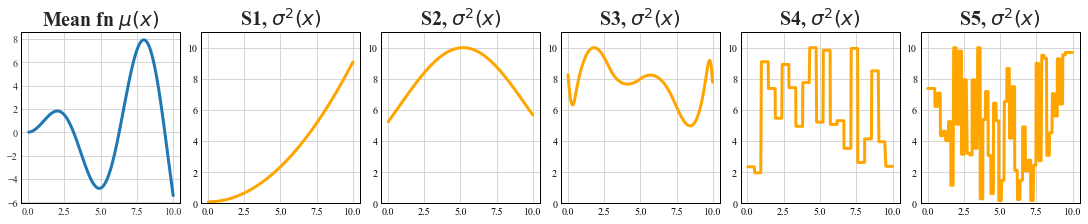

In [6]:
fig, axs = plt.subplots(1,6,figsize=(15,3),constrained_layout=True)
for ds_id, ds_str in enumerate(['ds1','ds2','ds3','ds4','ds5']):
    ## load test data
    file_test = f'{data_folder}/{ds_str}/0_test.pickle'
    with open(file_test, 'rb') as handle:
        data_test = pickle.load(handle)
    if ds_id == 0:
        x, true_mean = zip(*sorted(zip(data_test['x'], data_test['true_mean'])))
        axs[0].plot(x, true_mean,linewidth=3)
        axs[0].set_title(r'Mean fn $\mu(x)$',fontweight='bold',fontsize=20)
    
    x, true_var = zip(*sorted(zip(data_test['x'], data_test['true_var'])))
    axs[ds_id+1].plot(x, true_var,color='orange',linewidth=3)
    
    axs[ds_id+1].set_title(f'S{ds_id+1}, $\sigma^2(x)$',fontweight="bold",fontsize=20)
    
    axs[ds_id+1].tick_params(axis='x', colors='k') 
    axs[ds_id+1].tick_params(axis='y', colors='k')
    axs[ds_id+1].patch.set_edgecolor('black')  
    
    axs[ds_id+1].set_ylim(0,11)
    
fig.savefig(f'{output_folder}/paper/fig1.png',facecolor='w')

### Generate the prediction conf band, Figure 2 in the manuscript

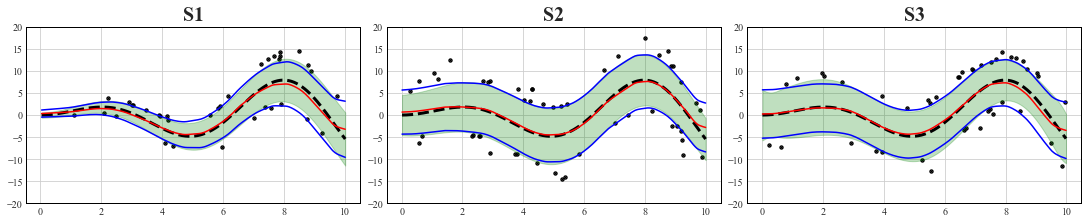

In [7]:
fig, axs = plt.subplots(1,3,figsize=(15,3),constrained_layout=True)
for ds_id, ds_str in enumerate(['ds1','ds2','ds3']):
    
    ## load test data
    file_test = f'{data_folder}/{ds_str}/0_test.pickle'
    with open(file_test, 'rb') as handle:
        data_test = pickle.load(handle)
    
    ## load estimates
    file_est = f'{output_folder}/{ds_str}/0_test_trainsize30000.pickle'
    with open(file_est, 'rb') as handle:
        estimates = pickle.load(handle)
    
    mean_est = estimates['mean_est'].squeeze()
    var_est = estimates['var_est_nll'].squeeze()
    
    # Sort coordinate values for plotting purpose
    temp = pd.DataFrame({'x':data_test['x'].squeeze(), 
                         'y': data_test['y'].squeeze(),
                         'true_mean': data_test['true_mean'].squeeze(), 
                         'true_var': data_test['true_var'].squeeze(),
                         'plus2': data_test['true_mean'].squeeze() + 2*np.sqrt(data_test['true_var'].squeeze()),
                         'minus2':data_test['true_mean'].squeeze() - 2*np.sqrt(data_test['true_var'].squeeze()),
                         'mean_est': mean_est,
                         'mean_est_plus2': np.squeeze(mean_est + 2*np.sqrt(var_est)),
                         'mean_est_minus2': np.squeeze(mean_est - 2*np.sqrt(var_est)),
                        })
    
    temp.sort_values(by='x', ascending=True,inplace=True)
    
    axs[ds_id].set_ylim(-20,20)
    
    axs[ds_id].plot(temp['x'],temp['true_mean'],color='black',linewidth=3,linestyle='dashed',label='mean (truth)')
    axs[ds_id].scatter(temp.loc[temp['y']>temp['plus2'],'x'],temp.loc[temp['y']>temp['plus2'],'y'],s = 2,color='k',linewidth=3,label='mean (truth)')
    axs[ds_id].scatter(temp.loc[temp['y']<temp['minus2'],'x'],temp.loc[temp['y']<temp['minus2'],'y'],s = 2,color='k',linewidth=3,label='mean (truth)')
    
    axs[ds_id].fill_between(temp['x'],temp['plus2'],temp['minus2'],color='green',label='-2 std dev (truth)',alpha=0.25)

    axs[ds_id].plot(temp['x'],temp['mean_est'],color='red',label='mean (est)')
    axs[ds_id].plot(temp['x'],temp['mean_est_plus2'],color='blue',label='+2 std dev (est)')
    axs[ds_id].plot(temp['x'],temp['mean_est_minus2'],color='blue',label='-2 std dev (est)')
    
    axs[ds_id].set_title(f"S{ds_id+1}",fontsize=20,fontweight='bold')

fig.savefig(f'{output_folder}/paper/fig2.png',facecolor='w')

### Compare different regions: Figures 3&4, Table 2 in the manuscript

In [8]:
def eval_single_run_multiple_cuts(ds_str, train_size, cuts_pct, data_folder, output_folder):
    """evaluate a single (ds, train_size) combo for different cuts of the variance (across all replica)"""
    eval_by_cut = []
    for replica_id in range(10):
        
        ## load test data
        file_test = f'{data_folder}/{ds_str}/{replica_id}_test.pickle'
        with open(file_test, 'rb') as handle:
            data_test = pickle.load(handle)
        cuts = np.quantile(data_test['true_var'],cuts_pct)

        ## load estimates
        file_est = f'{output_folder}/{ds_str}/{replica_id}_test_trainsize{train_size}.pickle'
        with open(file_est, 'rb') as handle:
            estimates = pickle.load(handle)
        if not np.sum((data_test['x'] - estimates['x'])**2) < 1e-4:
            print(f"train_size = {train_size}, replica_id = {replica_id}, delta = {np.sum((data_test['x'] - estimates['x'])**2):.5f}")
            #return
        del estimates['x']

        ## for the segmented rage
        for i in range(1,len(cuts)):
            cut_low, cut_high = cuts[i-1], cuts[i]

            row_base = {'ds': ds_str, 'replica_id': replica_id, 'train_size': train_size, 'range_pct': cuts_pct[i]}
            valid_indices = np.where( (data_test['true_var'].squeeze() > cut_low) & (data_test['true_var'].squeeze() < cut_high))[0]
            
            eval_collect = []
            for key, est in estimates.items():
                if 'mean' in key:
                    rpt_eval = evaluator.report(est[valid_indices],data_test['true_mean'][valid_indices])
                else:
                    rpt_eval = evaluator.report(est[valid_indices],data_test['true_var'][valid_indices])
                row = {**row_base, 'quantity': key, **rpt_eval}
                eval_collect.append(row)

            eval_by_cut.append(pd.DataFrame(eval_collect))

    eval_by_cut = pd.concat(eval_by_cut)
    return eval_by_cut

In [9]:
all_cuts = []
for ds_str in ['ds4', 'ds5']:
    for train_size in train_sizes:
        eval_by_cut = eval_single_run_multiple_cuts(ds_str, train_size=train_size, cuts_pct = np.arange(0,1.1,0.25), data_folder = data_folder, output_folder = output_folder)
        all_cuts.append(eval_by_cut)

df_cuts = pd.concat(all_cuts).groupby(['ds','train_size', 'range_pct','quantity']).agg({'rmse':['mean','std']})
df_cuts.columns = [f'{x[0]}_{x[1]}' for x in df_cuts.columns]
df_cuts = df_cuts.reset_index()

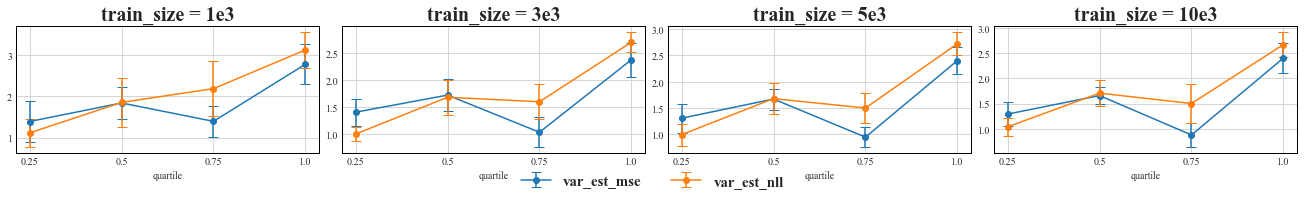

In [10]:
ds4 = df_cuts.loc[df_cuts['ds']=='ds4']

fig, axs = plt.subplots(1,len(train_sizes),figsize=(18,2.5),constrained_layout=True)
for size_id, train_size in enumerate(train_sizes):     
    for qt in ['var_est_mse', 'var_est_nll']:
        df_mean = ds4.loc[ (ds4['train_size']==train_size) & (ds4['quantity'] == qt)]
        axs[size_id].errorbar(df_mean['range_pct'], df_mean['rmse_mean'],yerr=df_mean['rmse_std'],label=qt, marker='o',capsize=5)
    axs[size_id].set_title(f'train_size = {train_size/1000:.0f}e3',fontweight='bold',fontsize=20)
    axs[size_id].set_xlabel('quartile')
    axs[size_id].set_xticks(df_mean['range_pct'],df_mean['range_pct'])
fig.legend(['var_est_mse','var_est_nll'],ncol=2,loc="lower center",prop={'weight':'bold','size': 15},bbox_to_anchor=(0.5, -0.1))
fig.savefig(f'output_sim/paper/fig3.png',facecolor='w')

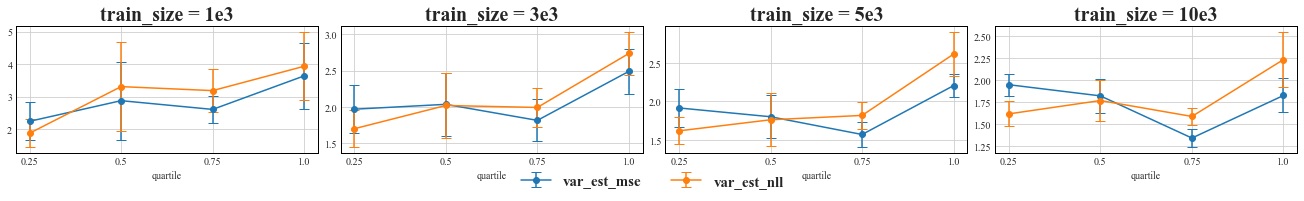

In [11]:
ds5 = df_cuts.loc[df_cuts['ds']=='ds5']

fig, axs = plt.subplots(1,len(train_sizes),figsize=(18,2.5),constrained_layout=True)
for size_id, train_size in enumerate(train_sizes):     
    for qt in ['var_est_mse', 'var_est_nll']:
        df_mean = ds5.loc[ (ds5['train_size']==train_size) & (ds5['quantity'] == qt)]
        axs[size_id].errorbar(df_mean['range_pct'], df_mean['rmse_mean'],yerr=df_mean['rmse_std'],label=qt, marker='o',capsize=5)
    axs[size_id].set_title(f'train_size = {train_size/1000:.0f}e3',fontweight='bold',fontsize=20)
    axs[size_id].set_xlabel('quartile')
    axs[size_id].set_xticks(df_mean['range_pct'],df_mean['range_pct'])
fig.legend(['var_est_mse','var_est_nll'],ncol=2,loc="lower center",prop={'weight':'bold','size': 15},bbox_to_anchor=(0.5, -0.1))
fig.savefig(f'output_sim/paper/fig4.png',facecolor='w')

In [12]:
pd.options.display.float_format = "{:,.2f}".format
rmse_by_region = df_cuts.pivot_table(index=['ds','train_size','quantity'],columns=['range_pct'],values=['rmse_mean','rmse_std']).reset_index()
rmse_by_region.loc[rmse_by_region['quantity']!='mean_est'].to_csv(f'{output_folder}/paper/table2.csv')

### Generate RMSE for ds1-ds3, Table 1 in the manuscript

In [13]:
def eval_single_run(ds_str, train_size, data_folder, output_folder):
    df_eval = []
    for replica_id in range(10):
        
        ## load test data
        file_test = f'{data_folder}/{ds_str}/{replica_id}_test.pickle'
        with open(file_test, 'rb') as handle:
            data_test = pickle.load(handle)

        ## load estimates
        file_est = f'{output_folder}/{ds_str}/{replica_id}_test_trainsize{train_size}.pickle'
        with open(file_est, 'rb') as handle:
            estimates = pickle.load(handle)
        if not np.sum((data_test['x'] - estimates['x'])**2) < 1e-4:
            print(f"train_size = {train_size}, replica_id = {replica_id}, delta = {np.sum((data_test['x'] - estimates['x'])**2):.5f}")
            return
        del estimates['x']

        row_base = {'ds': ds_str, 'replica_id': replica_id, 'train_size': train_size}
        eval_collect = []
        for key, est in estimates.items():
            if 'mean' in key:
                rpt_eval = evaluator.report(est,data_test['true_mean'])
            else:
                rpt_eval = evaluator.report(est,data_test['true_var'])
            
            row = {**row_base, 'quantity': key, **rpt_eval}
            eval_collect.append(row)

        df_eval.append(pd.DataFrame(eval_collect))
        
    df_eval = pd.concat(df_eval)
    return df_eval

In [14]:
df_eval_all = []
for ds_str in ['ds1', 'ds2', 'ds3']:
    for train_size in train_sizes:
        df_eval = eval_single_run(ds_str, train_size, data_folder = data_folder, output_folder = output_folder)
        df_eval_all.append(df_eval)
df_eval_all = pd.concat(df_eval_all)

In [15]:
df_eval = df_eval_all.groupby(['ds', 'train_size', 'quantity']).agg({'rmse': ['median','std']}).reset_index().sort_values(by=['train_size'])

In [16]:
df_eval.sort_values(by=['ds','train_size']).to_csv(f'{output_folder}/paper/table1.csv')